# Dall-E Mega Notebook


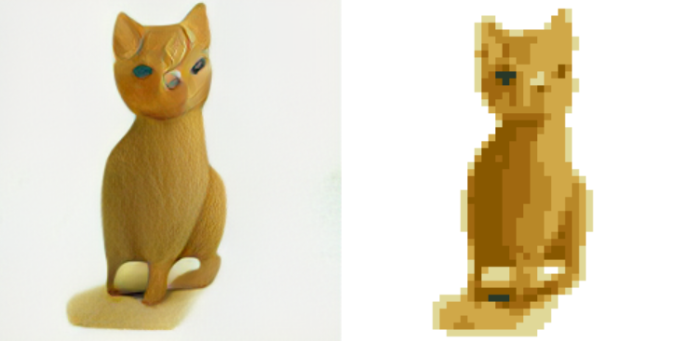



In [1]:
# Using clip will associate a score with every image
use_clip = False
# If this is set to False Dall-E mini will be used
use_dalle_mega = False

# Generating Images:

After running the setup cells, scroll down to the "🎨 Generate images" cells for instructions on how to generate images from a prompt.


## 🛠️ Installation and set-up

In [2]:
# Install required libraries
# Ignore pip dependencies error 
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git
!pip install -q git+https://github.com/borisdayma/dalle-mini.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/sedthh/pyxelate.git --upgrade

  Cloning https://github.com/sedthh/pyxelate.git to /tmp/pip-req-build-34a369_s
  Running command git clone --filter=blob:none --quiet https://github.com/sedthh/pyxelate.git /tmp/pip-req-build-34a369_s
  Resolved https://github.com/sedthh/pyxelate.git to commit ae2de9249d11063d0c1563b8e30a634c7d07faf8
  Preparing metadata (setup.py) ... done


We load required models:
* dalle·mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [3]:
# Model references

if use_dalle_mega:
  # dalle-mega
  DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"
else:
  # dalle-mini
  DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"  
DALLE_COMMIT_ID = None

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [4]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

## Important: Read this
This cell will request a token the first time you run the notebook. wait for it to print a link. Open the link and create an account with "Weights and Biases". Then copy paste the token in the prompt and press enter. 

Note: when creating the account, it will ask you to create a team. Just press skip.

In [5]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel


# Load dalle-mini
model, params = DalleBart.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False)

# Load VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:0
/home/ritabt/Dall-E-Alchemist/env/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [6]:
if use_clip:
  # CLIP model
    CLIP_REPO = "openai/clip-vit-large-patch14"
    CLIP_COMMIT_ID = None
    from transformers import CLIPProcessor, FlaxCLIPModel
  # Load CLIP
    clip = FlaxCLIPModel.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
    clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)

Model parameters are replicated on each device for faster inference.

In [7]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan._params = replicate(vqgan.params)
if use_clip:
    clip._params = replicate(clip.params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [8]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

if use_clip:
    # score images
    @partial(jax.pmap, axis_name="batch")
    def p_clip(inputs, params):
        logits = clip(params=params, **inputs).logits_per_image
        return logits

Our model requires processing prompts.

In [9]:
# This takes ~15s
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:0


### Function wrapper for generating images

In [10]:
from flax.training.common_utils import shard
from flax.training.common_utils import shard_prng_key
from tqdm.notebook import trange
from pyxelate import Pyx, Pal
from skimage import io
from PIL import Image
import numpy as np
import random

# Set up drive folder path
img_folder = "./images/"

def pixelate_img(image, pix_args, filename, idx, save):
    image = np.array(image)
    factor = pix_args["factor"]
    palette = pix_args["palette"]
    dither = pix_args["dither"]
    upscale = pix_args["upscale"]
    alpha = pix_args["alpha"]
    pix_img = Pyx(factor=factor, palette=palette, dither=dither, upscale=upscale, alpha=alpha).fit_transform(image)
    print("Pixelated image:")
    pix_img = Image.fromarray(pix_img, 'RGB')
    display(pix_img)
    img_filename = filename + "_pixelated_" + str(idx)+ ".png"
    if save:
        pix_img.save(img_folder+img_filename, format="png")

def get_images(prompt, n_predictions, filename=None, pixelate=False, pix_args=None, save=False):
    # Create random key
    seed = random.randint(0, 2**32 - 1)
    key = jax.random.PRNGKey(seed)
    # Process prompt
    tokenized_prompt = processor([prompt])
    # Replicate prompt on each device
    tokenized_prompt = replicate(tokenized_prompt)
    # We can customize top_k/top_p used for generating samples
    gen_top_k = None
    gen_top_p = None
    temperature = None
    cond_scale = 3.0

    # generate images
    images = []
    for i in trange(max(n_predictions // jax.device_count(), 1)):
        # get a new key
        key, subkey = jax.random.split(key)
        # generate images
        encoded_images = p_generate(
          tokenized_prompt,
          shard_prng_key(subkey),
          params,
          gen_top_k,
          gen_top_p,
          temperature,
          cond_scale,
        )
        # remove BOS
        encoded_images = encoded_images.sequences[..., 1:]
        # decode images
        decoded_images = p_decode(encoded_images, vqgan.params)
        decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
        for img in decoded_images:
            images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

    if use_clip:
        # get clip scores
        clip_inputs = clip_processor(
            text=[prompt] * jax.device_count(),
            images=images,
            return_tensors="np",
            padding="max_length",
            max_length=77,
            truncation=True,
        ).data
        logits = p_clip(shard(clip_inputs), clip.params)
        logits = logits.squeeze().flatten()

    # If filename is not specified replace spaces in prompt with "_"
    if filename is None:
        filename_separated = prompt.split()
        filename = "_".join(filename_separated)

    # Display and save images
    print(f"Prompt: {prompt}\n")
    if use_clip: # sort from highest to lowest clip score
        for idx in logits.argsort()[::-1]:
            display(images[idx])
            print(f"Score: {logits[idx]:.2f}\n")
            img_filename = filename + "_img_" + str(idx)+ ".png"
            img_path = img_folder+img_filename
            if save:
                images[idx].save(img_path, format="png")
            if pixelate:
                pixelate_img(images[idx], pix_args, filename, idx, save)
    else:
        for idx in range(len(images)):
            display(images[idx])
            img_filename = filename + "_img_" + str(idx)+ ".png"
            img_path = img_folder+img_filename
            if save:
                images[idx].save(img_path, format="png")
            if pixelate:
                pixelate_img(images[idx], pix_args, filename, idx, save)

# 🎨 Generate images

### Note on Pixelator:

You can select to pixelate the generated images. The pixelating function takes a few arguments. To learn what each argument does, see documentation here: https://github.com/sedthh/pyxelate#hyperparameters-for-pyx

You can also experiment with different values until you get what you want. Change factor and upscale for different pixel sizes.

## Generate from a Prompt:
The cell below lets you generate images for 1 prompt.

Replace the text for prompt with your own prompt and set the number of images you would like generated for that prompt.

The function that generates the images is random, so each time you run the cell below, you will get different outputs.

Keep scrolling for cells that take multiple prompts.


In [ ]:
# Write your prompt here
prompt = "wooden cat"

# Set this to True if you want the images to be saved in the images folder
# If you are experimenting set this to False to not use up a lot of memory!
save = False

# Write the number of images you want generated
# On Colab:
# Dall-E Mini takes <5s per image
# Dall-E Mega takes ~30s per image
num_images = 2

# Set this to False if you don't want pixelated images
pixelate = True
# These are the arguments for the pixelating function
pix_args = {"factor":5, "palette":7, "dither":"naive", "upscale":5, "alpha":.6}

# This will generate and display the images!
get_images(prompt, num_images, pixelate=pixelate, pix_args=pix_args, save=save)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/ritabt/Dall-E-Alchemist/env/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
/home/ritabt/Dall-E-Alchemist/env/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


## Generate Multiple Prompts:

Edit the prompts list for all the prompts you'd like generated. 

The num_images variable is the number of images generated for each prompt.

If you'd like to control how many images are generated per prompt use the next cell.

In [ ]:
prompts = [
           "a candy cane sword", 
           "a cube made out of green grass", 
           "a hat made out of bread",
           ]

save = False
num_images = 4

pixelate = True
pix_args = {"factor":5, "palette":7, "dither":"naive", "upscale":5, "alpha":.6}

for p in prompts:
    get_images(p, num_images, pixelate=pixelate, pix_args=pix_args, save=save)
  

## Extra Arguments Control

Modify the prompts and number of images to control how many images are generated per prompt.

In [ ]:
prompts = [
           "wooden cat", 
           "plastic dog", 
           ]

num_imgs = [1, 2]

save = False
pixelate = True
pix_args = {"factor":5, "palette":7, "dither":"naive", "upscale":5, "alpha":.6}

## Optional: 
# You can specify the filename of the saved image
# Pass this list as a third argument (add to zip and get individual elements)
filenames = ["wood_cat", "plastic_dog"]
# This can be helpful later on to organize image names from cards combined

for p, n, f in zip(prompts, num_imgs, filenames):
    get_images(p, n, filename=f, pixelate=pixelate, pix_args=pix_args, save=save)